In [66]:
import pandas as pd
#import italy covid cases
df_covid_iqa = pd.read_csv('covid_iqa.csv',delimiter=',', keep_default_na=False, na_values=[''])
df_covid_iqa.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note,IQA
0,2020-02-24,ITA,15,Campania,63,Napoli,NA,40.839566,14.250850,0,NaN,60.0
1,2020-02-24,ITA,8,Emilia-Romagna,37,Bologna,BO,44.494367,11.341721,0,NaN,90.0
2,2020-02-24,ITA,12,Lazio,58,Roma,RM,41.892770,12.483667,0,NaN,50.0
3,2020-02-24,ITA,3,Lombardia,15,Milano,MI,45.466794,9.190347,0,NaN,98.0
4,2020-02-24,ITA,3,Lombardia,17,Brescia,BS,45.539931,10.219103,0,NaN,98.0


In [67]:
# select city
df_covid_iqa = df_covid_iqa.loc[df_covid_iqa['denominazione_provincia'].isin(['Roma'])]
df_covid_iqa.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note,IQA
2,2020-02-24,ITA,12,Lazio,58,Roma,RM,41.89277,12.483667,0,NaN,50.0
8,2020-02-25,ITA,12,Lazio,58,Roma,RM,41.89277,12.483667,3,NaN,34.0
14,2020-02-26,ITA,12,Lazio,58,Roma,RM,41.89277,12.483667,3,NaN,30.0
20,2020-02-27,ITA,12,Lazio,58,Roma,RM,41.89277,12.483667,3,NaN,26.0
26,2020-02-28,ITA,12,Lazio,58,Roma,RM,41.89277,12.483667,3,NaN,34.0


In [68]:
# statistiche descrittive qualità aria
y= df_covid_iqa["IQA"]
stats = y.describe()
stats.loc['var'] = y.var()
stats.loc['skew'] = y.skew()
stats.loc['kurt'] = y.kurtosis()
print("statistiche descrittive qualita dell'aria")
print(stats)
# statistiche descrittive delta giornalieri

statistiche descrittive qualita dell'aria
count    158.000000
mean      36.280063
std       14.651596
min       12.000000
25%       27.083333
50%       33.000000
75%       40.000000
max      110.000000
var      214.669251
skew       2.075773
kurt       6.610015
Name: IQA, dtype: float64


Test normality for covid cases
Statistics = 26.068, p=0.000
Data looks non-Gaussian (reject null hypothesis)
Test normality for IQA
Statistics = 85.452, p=0.000
Data looks non-Gaussian (reject null hypothesis)


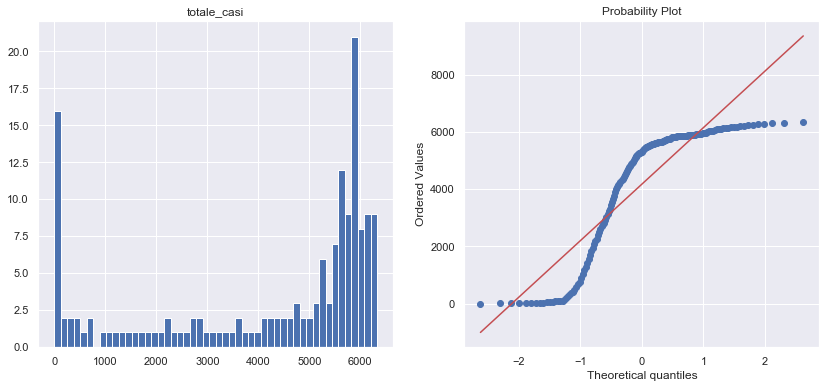

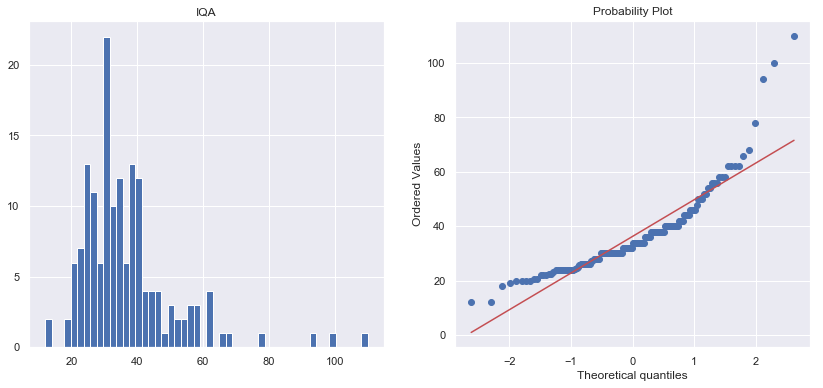

In [69]:
# Normal distribution test
import scipy
from scipy import stats
import matplotlib.pyplot as plt

print("Test normality for covid cases")
normality_test(df_covid_iqa['totale_casi'],"totale_casi")
print("Test normality for IQA")
normality_test(df_covid_iqa['IQA'],"IQA")

In [62]:
def normality_test(data,target):
    stat,p = stats.normaltest(data)
    print("Statistics = %.3f, p=%.3f" % (stat,p))
    alpha = 0.05
    if p> alpha:
        print('Data looks Gaussian (fail to reject null hypothesis)')
    else:
        print('Data looks non-Gaussian (reject null hypothesis)')

    #test normalità 
    jarque_bera_test = stats.jarque_bera(data)
    jarque_bera_test

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    data.hist(bins=50)
    plt.title(target)
    plt.subplot(1,2,2)
    stats.probplot(data, plot=plt);
    data.describe().T

             totale_casi   IQA_tr
totale_casi      1.00000  0.22659
IQA_tr           0.22659  1.00000


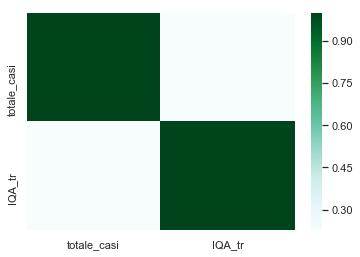

In [75]:
# Pearson correlation
import seaborn as sns; sns.set()
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# minmax scalar
scaler = MinMaxScaler()
df_covid_iqa['IQA_tr'] = scaler.fit_transform(df_covid_iqa[['IQA']])
df_covid_iqa['IQA_tr'] = 1- df_covid_iqa['IQA_tr'] 

# correlation matrix
corr = df_covid_iqa[["totale_casi","IQA_tr"]].corr(method='pearson')
print(corr)
sns.heatmap(corr, cmap="BuGn")

In [72]:
# Let's transform the series
y_tr_cases = transform_function(df_covid_iqa['totale_casi'])
y_tr_iqa = transform_function(df_covid_iqa['IQA'])

In [71]:
import numpy as np
def transform_function(df):
    df = df.apply(np.log).diff().dropna()
    #df = df.diff().dropna()
    return df

In [76]:
print("stationarity test for cases")
kpss_test(y_tr_cases)

stationarity test for cases
KPSS Statistic: nan
p-value: nan
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\g.donatiello\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1649: RuntimeWarning: invalid value encountered in subtract
  resids = x - x.mean()
C:\Users\g.donatiello\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


In [50]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
